<font size = 6 > **Телеком** </font>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Обозначения признаков**

- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги
- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

**Цель проекта**

Необходимо спрогнозировать, уйдет клиент или останется.

In [15]:
%%capture
!pip install catboost
!pip install lightgbm
!pip install eli5
!pip install shap
!pip install phik
!pip install explainerdashboard
!pip install scikit-plot

In [16]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from functools import reduce
import scikitplot as skplt
from numpy import nan as NA
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import precision_score,recall_score
import eli5 # permutation importance
import shap # shapley
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import datetime
from time import time
import warnings
warnings.filterwarnings('ignore')

### Посмотрим на данные

In [17]:
CONTRACT_DATASET = 'contract_new.csv'

In [18]:
PERSONAL_DATASET = 'personal_new.csv'

In [19]:
INTERNET_DATASET = 'internet_new.csv'

In [20]:
PHONE_DATASET = 'phone_new.csv'

In [21]:
contract_df = pd.read_csv(CONTRACT_DATASET)

In [22]:
personal_df = pd.read_csv(PERSONAL_DATASET)

In [23]:
internet_df = pd.read_csv(INTERNET_DATASET)

In [24]:
phone_df = pd.read_csv(PHONE_DATASET)

Посмотрим на таблицы последовательно

Contract

In [25]:
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [26]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков в данной таблице нет

Приводим к нижнему регистру названия столбцов

In [27]:
contract_df.columns = (contract_df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower())

In [28]:
contract_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

Столбец totalcharges имеет неправильный тип данных, исправим это

In [29]:
contract_df["total_charges"] = pd.to_numeric(contract_df["total_charges"], errors="coerce").fillna(0.0) # форматирование totalcharges

Названия столбцов приводим также к змеиному регистру

In [30]:
contract_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


Personal

In [31]:
personal_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [32]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков нет

In [33]:
personal_df.columns = (personal_df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower())

In [34]:
personal_df.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Phone

In [35]:
phone_df.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [36]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Число строк в таблице Phone меньше, вероятно, есть пропуски

In [37]:
phone_df.columns = (phone_df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower())

In [38]:
phone_df.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Internet

In [39]:
internet_df.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [40]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Число строк в таблице Internet меньше, вероятно, есть пропуски

In [41]:
internet_df.columns = (internet_df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower())

In [42]:
internet_df.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Объединяем таблицы

In [43]:
data = contract_df.merge(personal_df, on='customer_id', how='inner').merge(internet_df, on='customer_id', how='left').merge(phone_df, on='customer_id', how='left')

столбец customer_id переводим в индексы

In [44]:
data = data.set_index(['customer_id'])

In [45]:
data.shape

(7043, 19)

In [46]:
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   float64
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

In [48]:
data.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

В 8 столбцах содержатся пропуски, видимо среди клиентов есть те, кто пользуется только интернет-услугами или только услугами телефонии.



In [49]:
data = data.fillna('No')
data.isna().sum()

begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Объединение и заполнение пропусков сделаны корректно
    
</div>

Приведем данные в столбце begin_date в формат datetime

In [50]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')

In [51]:
print(data['begin_date'].dt.date.min())
print(data['begin_date'].dt.date.max())

2013-10-01
2020-02-01


Самая ранняя дата заключения договора 2013-10-01, самая поздняя - 2020-02-01

Посмотрим на даты окончания договоров

In [52]:
data['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Если даты закрытия договора нет и стоит метка "No", значит человек все еще является клиентов компании.

Создадим колонку с целевой переменной 'target', которая означает, является ли человек клиентом компании на момент выгрузки данных или нет.

Присвоим новой колонке 'target' значение 1 - если человек является клиентом компании (нет даты закрытия договора) и 0 - если клиент закрыл договор.

Создаем колонку с целевой переменной

In [53]:
data.loc[data['end_date'] == 'No', 'target'] = 1
data.loc[~(data['end_date'] == 'No'), 'target'] = 0

приводим данные в столбце 'target' к целочисленном типу

In [54]:
data['target'] = data['target'].astype(int)

In [55]:
data['target'].value_counts(normalize=True)

1    0.843675
0    0.156325
Name: target, dtype: float64

Видно, что классы не сбалансированы: оставшиеся клиенты составляют около 85% выборки, а ушедшие 15%.

Если человек является клиентом компании укажем в столбце 'end_date' дату выгрузки базы

In [56]:
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'

приведем данные в столбце 'end_date' к формату datetime

In [57]:
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

In [58]:
data['end_date'].value_counts(normalize=True)

2020-02-01    0.843675
2020-01-01    0.005537
2019-12-01    0.005395
2018-11-01    0.004969
2019-09-01    0.004544
                ...   
2014-09-01    0.000284
2014-12-01    0.000284
2014-06-01    0.000142
2014-10-01    0.000142
2014-11-01    0.000142
Name: end_date, Length: 67, dtype: float64

создадим новый столбец 'days_in_company' указанием, сколько дней человек являлся или является клиентом компании

In [59]:
data['days_in_company'] = (data['end_date'] - data['begin_date']).dt.days

удалим уже не нужные столбцы 'begin_date' и 'end_date'

In [60]:
data = data.drop(columns=['begin_date', 'end_date'])

In [61]:
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,days_in_company
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,1,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,153


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

Посмотрим корреляцию между признаками в полученном датафрейме

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'days_in_company']


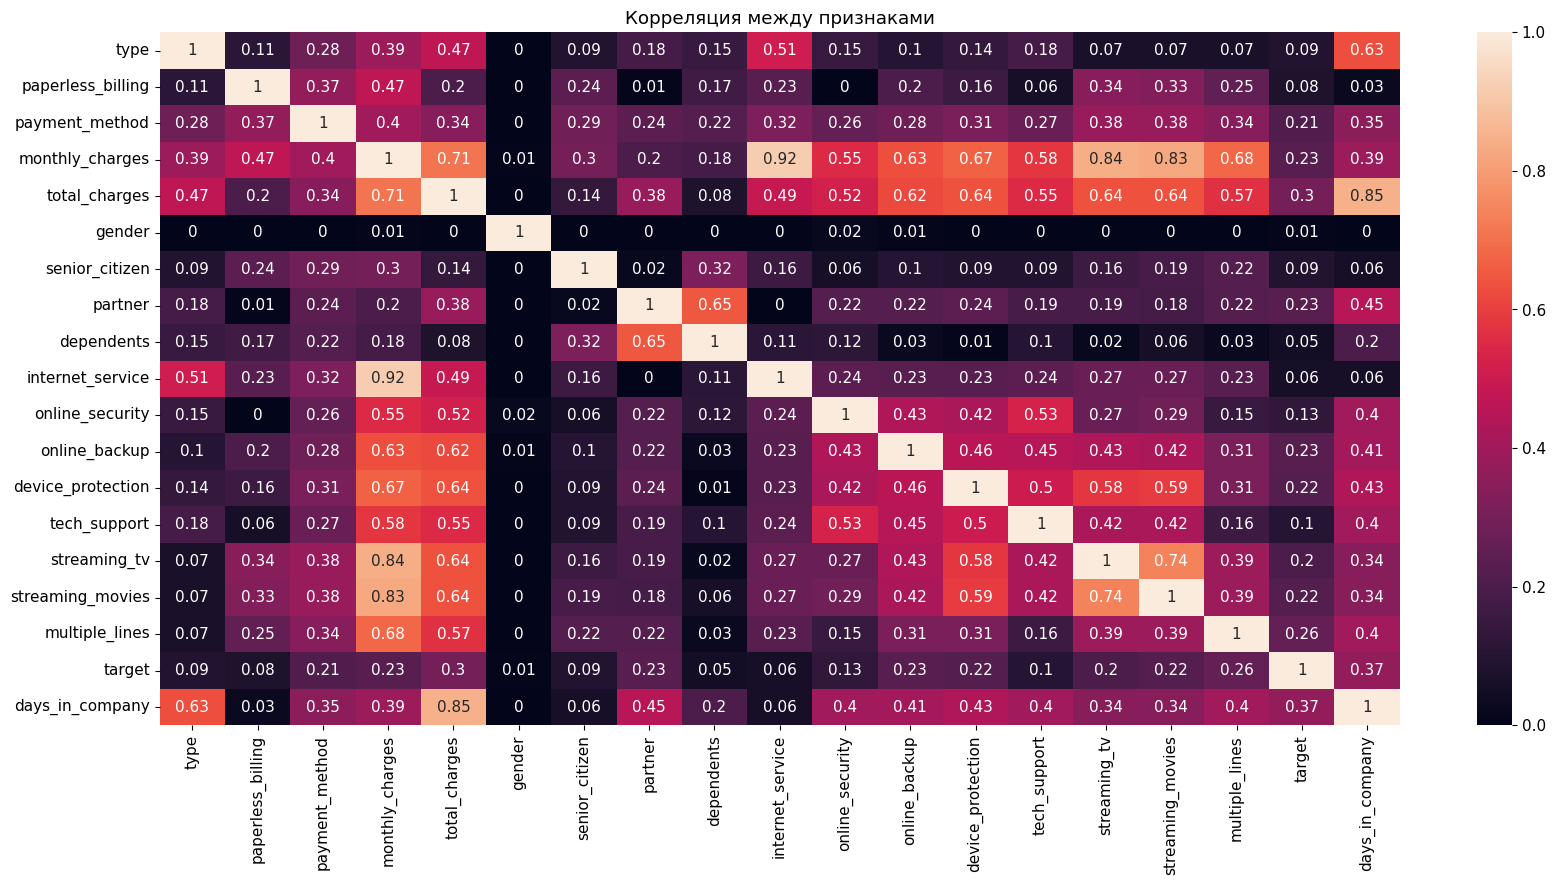

In [63]:
plt.rc('font', size= 11)
plt.figure(figsize=(20, 9))
sns.heatmap(data.phik_matrix().round(2), annot = True)
plt.title('Корреляция между признаками')
plt.show();

По тепловой карте можно предположить, что пол клиента ни на что не влияет.
Видна высокая корреляции признаков 'monthly_charges' и 'total_charges' с другими признаками.

<Axes: xlabel='type', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от type')

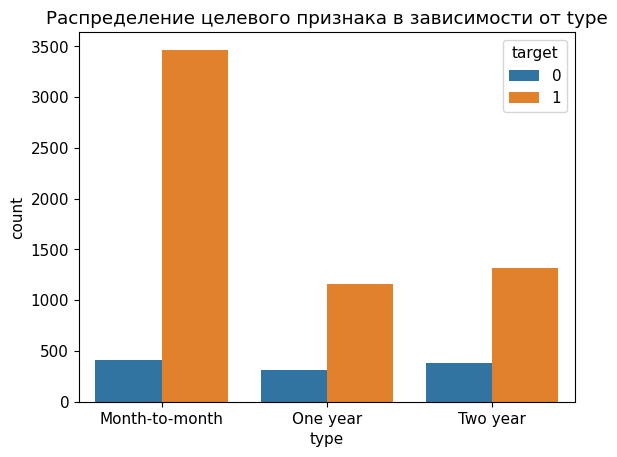

<Axes: xlabel='paperless_billing', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от paperless_billing')

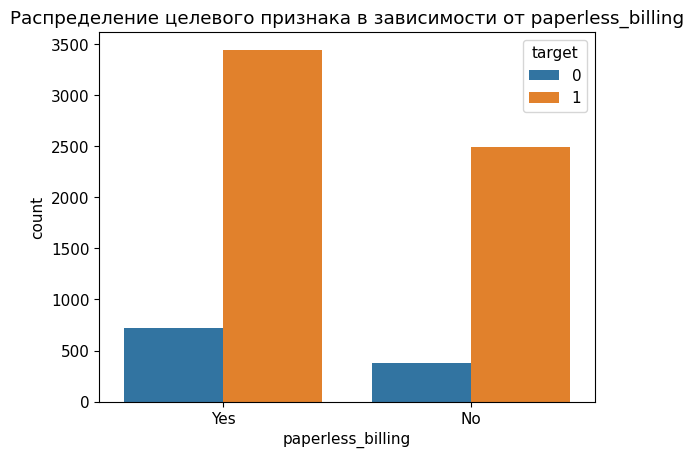

<Axes: xlabel='payment_method', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от payment_method')

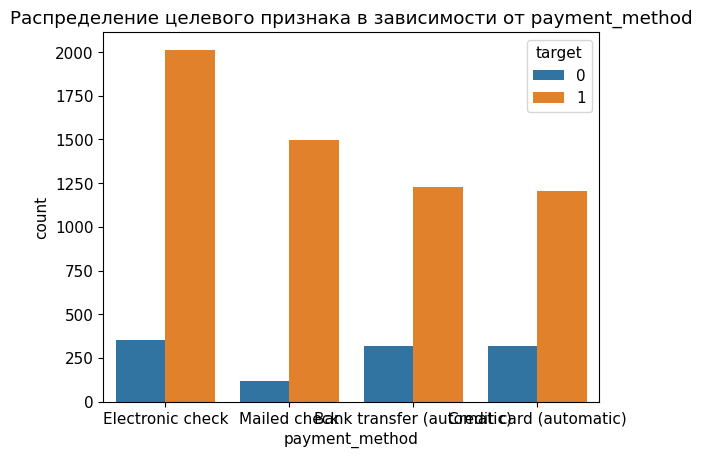

<Axes: xlabel='gender', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от gender')

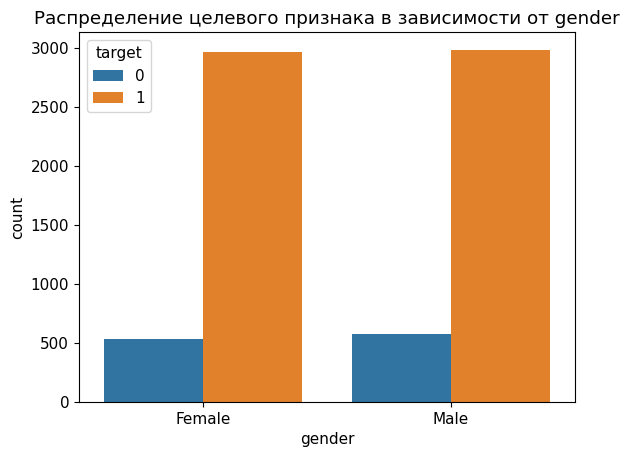

<Axes: xlabel='senior_citizen', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от senior_citizen')

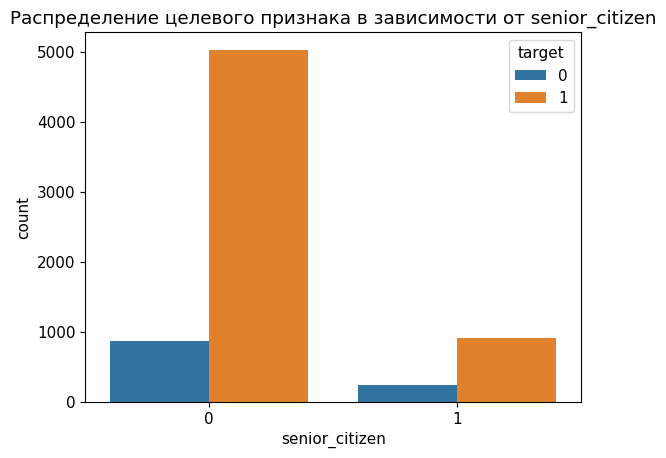

<Axes: xlabel='partner', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от partner')

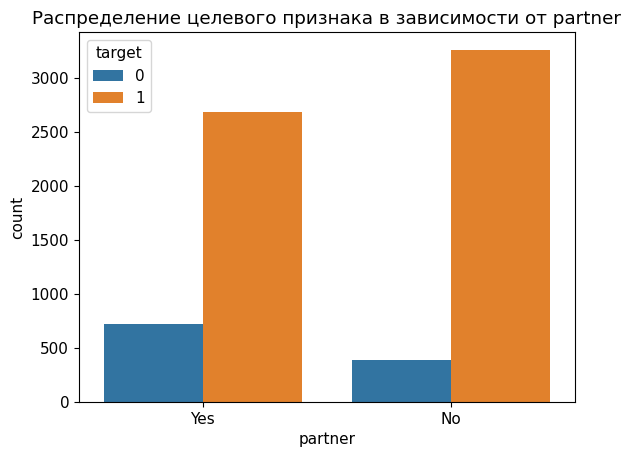

<Axes: xlabel='dependents', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от dependents')

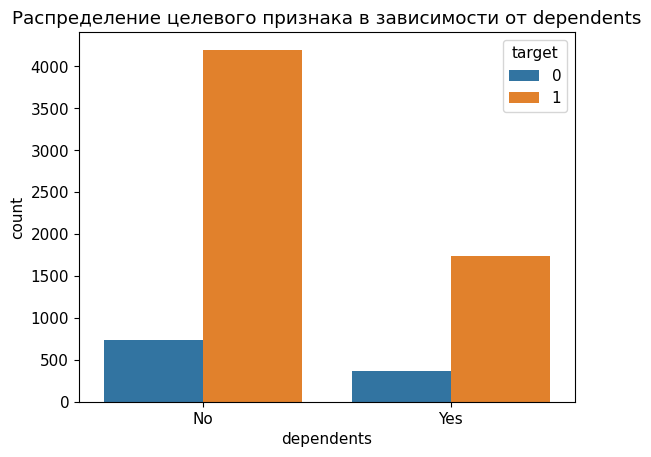

<Axes: xlabel='internet_service', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от internet_service')

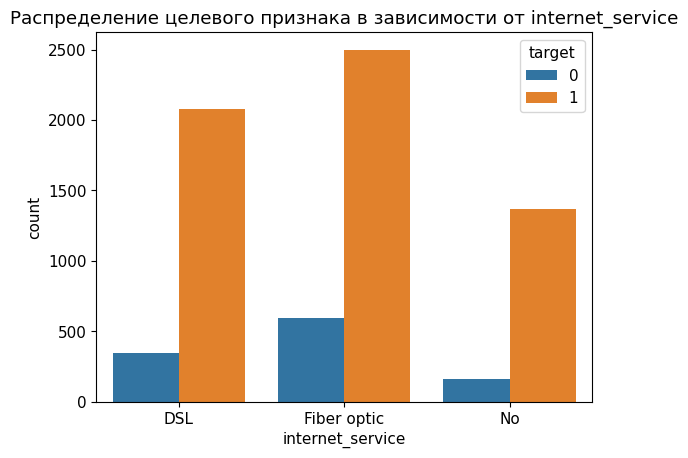

<Axes: xlabel='online_security', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от online_security')

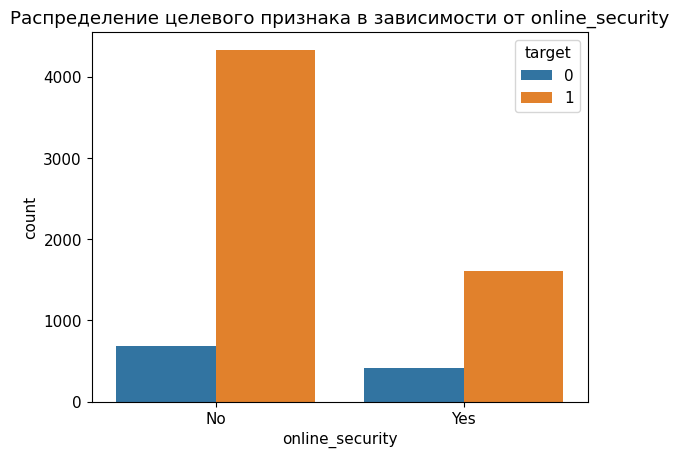

<Axes: xlabel='online_backup', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от online_backup')

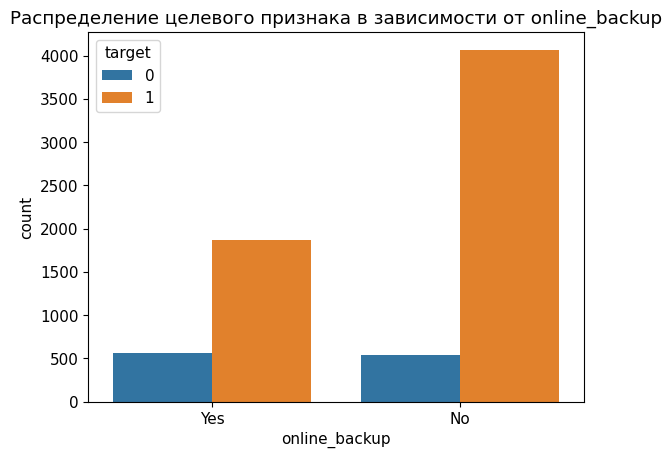

<Axes: xlabel='device_protection', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от device_protection')

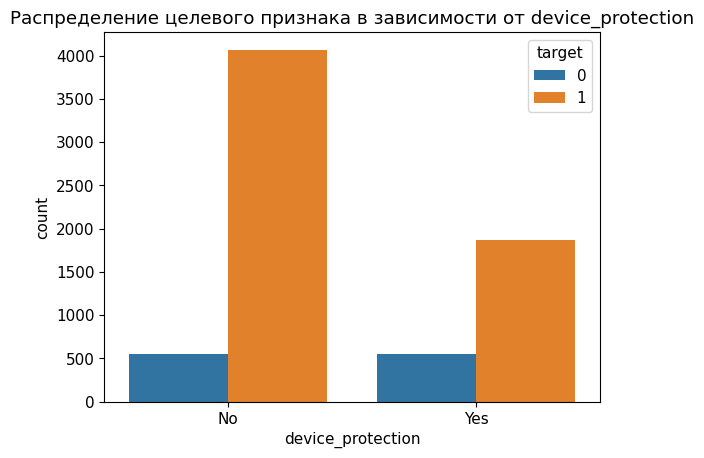

<Axes: xlabel='tech_support', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от tech_support')

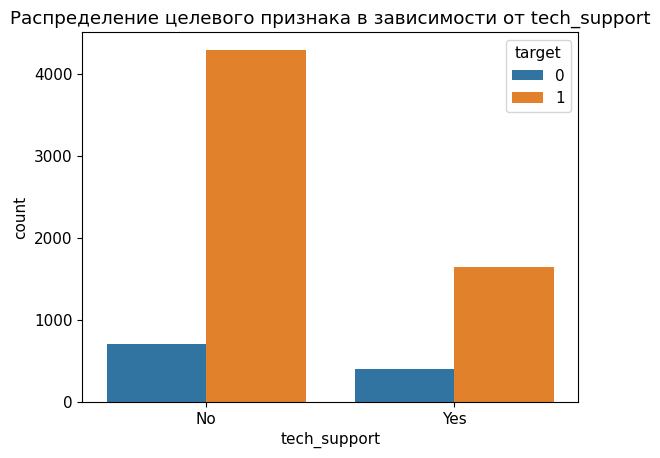

<Axes: xlabel='streaming_tv', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от streaming_tv')

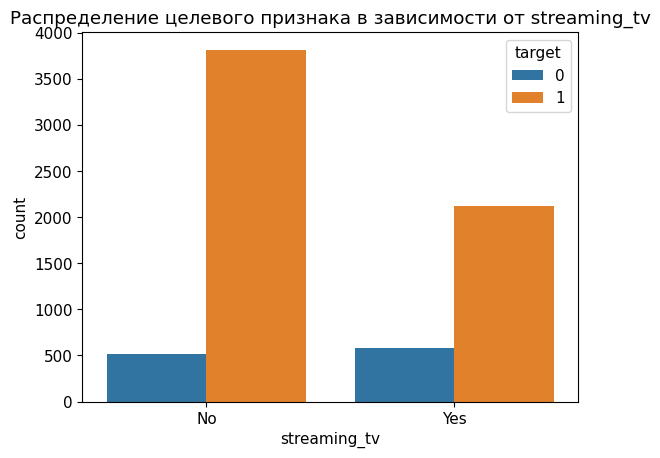

<Axes: xlabel='streaming_movies', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от streaming_movies')

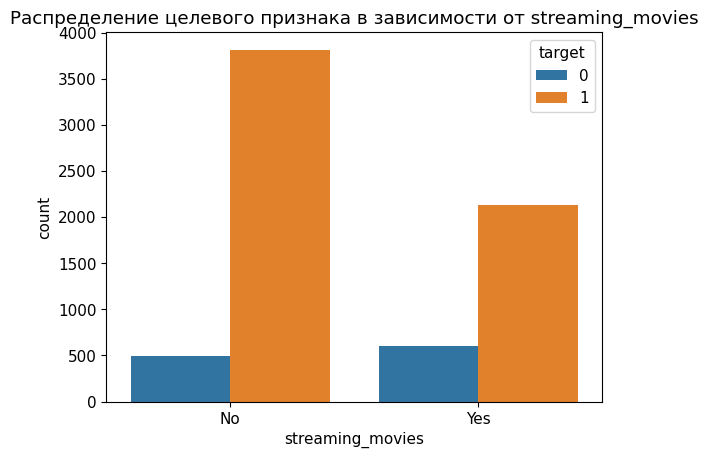

<Axes: xlabel='multiple_lines', ylabel='count'>

Text(0.5, 1.0, 'Распределение целевого признака в зависимости от multiple_lines')

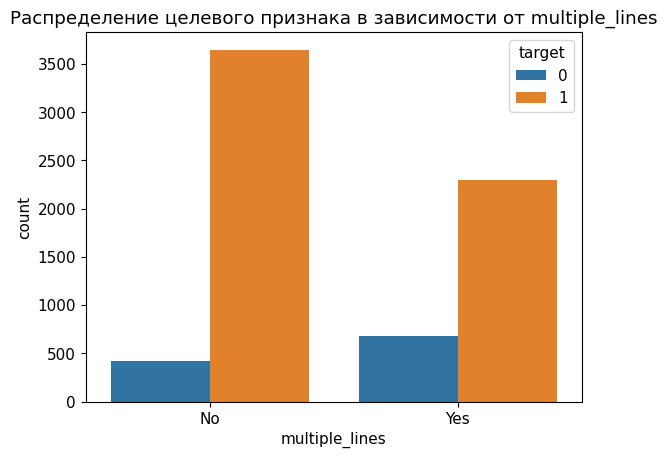

In [64]:
cat_list = [column for column in data.columns if data[column].nunique() < 15 and column != 'target']

for cat in cat_list:
    sns.countplot(x = data[cat], hue = data['target'])
    plt.title(f'Распределение целевого признака в зависимости от {cat}')
    plt.show()

Можно предположить, что пол клиента не влияет на целевой признак. Удалим столбец 'gender'.

In [65]:
data =  data.drop(columns=['gender'])

### Выводы

1. Исходные таблицы объедидены в одну, проанализированы пропущенные значения
2. Созданы новые признаки и целевой признак
3. Присутствует дисбаланс классов в распределении целевого признака
4. Проведен анализ признаков
5. Удален неинформативный признак 'gender'

**План**

1. Разбиение датасета на выборки
2. Кодирование категориальных признаков
3. Подбор гиперпараметров
4. Рассмотрю модели логистической регрессия,случайный лес, бустинги
5. Выбор лучшей модели
6. Анализ метрик roc_auc, accuracy, построение матрицы ошибок
7. Анализ важности признаков выбранной модели (SHAP, permutation impotance)

Разбиваем датасет на выборки

In [66]:
data = data.drop(['total_charges', 'monthly_charges'], axis=1)

In [67]:
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=310723, stratify=y)

In [68]:
X_train.dtypes

type                 object
paperless_billing    object
payment_method       object
senior_citizen        int64
partner              object
dependents           object
internet_service     object
online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
multiple_lines       object
days_in_company       int64
dtype: object

In [69]:
X_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'days_in_company'],
      dtype='object')

In [70]:
categorical = ['type', 'paperless_billing', 'payment_method', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']
numeric_features = ['days_in_company']

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop='first'), categorical),
    ('scaling', StandardScaler(), numeric_features),
])

X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)

In [71]:
new_features = list(ct.named_transformers_['ohe'].get_feature_names_out())
new_features.extend(numeric_features)

new_features

['type_One year',
 'type_Two year',
 'paperless_billing_Yes',
 'payment_method_Credit card (automatic)',
 'payment_method_Electronic check',
 'payment_method_Mailed check',
 'partner_Yes',
 'dependents_Yes',
 'internet_service_Fiber optic',
 'internet_service_No',
 'online_security_Yes',
 'online_backup_Yes',
 'device_protection_Yes',
 'tech_support_Yes',
 'streaming_tv_Yes',
 'streaming_movies_Yes',
 'multiple_lines_Yes',
 'days_in_company']

In [72]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=new_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=new_features)

X_train_transformed.head()

,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes,days_in_company
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.721012
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.076959
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.051124
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.917158
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.474488


In [73]:
model_lr = LogisticRegression(class_weight='balanced', random_state=310723)

params = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
           'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs_lr = GridSearchCV(model_lr, params, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gs_lr.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=310723),
             n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc', verbose=2)

In [74]:
gs_lr.best_score_, gs_lr.best_params_

(0.7498691830447498, {'penalty': 'l2', 'solver': 'sag'})

In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=310723)

params = {'max_depth': range(1, 32, 15),
          'min_samples_split': range(1, 61, 20),
          'n_estimators': range(100, 351, 50),
          'min_samples_leaf': range(1, 14, 4),
          'criterion': ['gini', 'entropy']}

gs_rf = GridSearchCV(model_rf, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_rf.fit(X_train_transformed, y_train)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=310723),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 32, 15),
                         'min_samples_leaf': range(1, 14, 4),
                         'min_samples_split': range(1, 61, 20),
                         'n_estimators': range(100, 351, 50)},
             scoring='roc_auc', verbose=2)

In [ ]:
gs_rf.best_score_, gs_rf.best_params_

LGBM c закодированными категориальными значениями

In [ ]:
model = LGBMClassifier(class_weight='balanced', random_state=310723)

params = {'n_estimators': range(20, 201, 40),
               'num_leaves': range(20, 201, 40),
               'max_depth': range(1, 22, 6),
               'learning_rate': [0.03, 0.1, 0.2, 0.4]}

gs_lgbm = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_lgbm.fit(X_train_transformed, y_train)

In [ ]:
gs_lgbm.best_score_, gs_lgbm.best_params_

LGBM без кодирования категориальных значений

In [ ]:
X_train_lgbm = X_train
X_train_lgbm[categorical] = X_train_lgbm[categorical].astype('category')
X_test_lgbm = X_test
X_test_lgbm[categorical] = X_test_lgbm[categorical].astype('category')

In [ ]:
model = LGBMClassifier(cat_features=categorical, class_weight='balanced', random_state=310723)

params = {'n_estimators': range(20, 201, 40),
               'num_leaves': range(20, 201, 40),
               'max_depth': range(1, 22, 6),
               'learning_rate': [0.03, 0.1, 0.2, 0.4]}

gs_lgbm_ = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_lgbm_.fit(X_train_lgbm, y_train)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits


In [ ]:
gs_lgbm_.best_score_, gs_lgbm_.best_params_

CatBoostClassifier без кодирования категориальных переменных

In [82]:
model = CatBoostClassifier(cat_features=categorical, random_state=310723)

params = {'learning_rate': [0.2, 0.4, 0.8],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [3, 5, 8],
        'iterations': [200, 250, 500]}

gs_ctb_ = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_ctb_.fit(X_train_lgbm, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits
0:	learn: 0.5548036	total: 54.7ms	remaining: 27.3s
1:	learn: 0.4730048	total: 61.3ms	remaining: 15.3s
2:	learn: 0.4227301	total: 68.1ms	remaining: 11.3s
3:	learn: 0.3970048	total: 74.1ms	remaining: 9.19s
4:	learn: 0.3820723	total: 79.9ms	remaining: 7.91s
5:	learn: 0.3686363	total: 86.2ms	remaining: 7.09s
6:	learn: 0.3574098	total: 92.7ms	remaining: 6.53s
7:	learn: 0.3526781	total: 98.3ms	remaining: 6.05s
8:	learn: 0.3517086	total: 102ms	remaining: 5.55s
9:	learn: 0.3466065	total: 108ms	remaining: 5.29s
10:	learn: 0.3428746	total: 113ms	remaining: 5.04s
11:	learn: 0.3387286	total: 119ms	remaining: 4.85s
12:	learn: 0.3367022	total: 125ms	remaining: 4.68s
13:	learn: 0.3358530	total: 131ms	remaining: 4.53s
14:	learn: 0.3337959	total: 136ms	remaining: 4.41s
15:	learn: 0.3303775	total: 142ms	remaining: 4.29s
16:	learn: 0.3295572	total: 147ms	remaining: 4.17s
17:	learn: 0.3277499	total: 152ms	remaining: 4.07s
18:	learn: 0.3269396	t

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostClassifier object at 0x7d444343e140>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'iterations': [200, 250, 500],
                         'l2_leaf_reg': [3, 5, 8],
                         'learning_rate': [0.2, 0.4, 0.8]},
             scoring='roc_auc', verbose=2)

In [83]:
gs_ctb_.best_score_, gs_ctb_.best_params_

(0.936320081822719,
 {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.2})

CatBoostClassifier с кодированием категориальных переменных

In [ ]:
model = CatBoostClassifier(random_state=310723)

params = {'learning_rate': [0.2, 0.4, 0.8],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [3, 5, 8],
        'iterations': [200, 250, 500]}

gs_ctb = GridSearchCV(model, params, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
gs_ctb.fit(X_train_transformed, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


In [ ]:
gs_ctb.best_score_, gs_ctb.best_params_

Выбираем модель CatBoostClassifier без кодирования категориальных переменных с roc_auc = 0.938 на тренировочной выборке.

In [86]:
pred_ctb_ = gs_ctb_.best_estimator_.predict_proba(X_test_lgbm)[:,1]

roc_auc_score(y_test, pred_ctb_)

0.9366670745136426

In [87]:
pred = gs_ctb_.best_estimator_.predict(X_test_lgbm)

Построим матрицу ошибок

              precision    recall  f1-score   support

           0       0.95      0.63      0.76       275
           1       0.94      0.99      0.96      1486

    accuracy                           0.94      1761
   macro avg       0.94      0.81      0.86      1761
weighted avg       0.94      0.94      0.93      1761



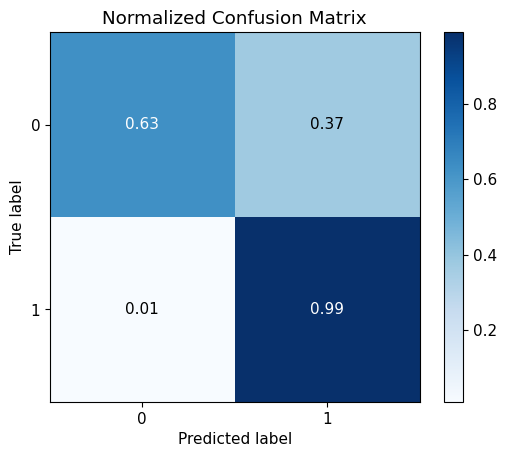

In [88]:
plt_gs_ctb = skplt.metrics.plot_confusion_matrix(y_test, pred, normalize=True)
print(classification_report(y_test, pred))

In [89]:
X_train_lgbm.shape

(5282, 15)

In [90]:
perm = eli5.sklearn.PermutationImportance(gs_ctb_.best_estimator_, random_state=310723).\
    fit(X_train_lgbm, y_train)

eli5.show_weights(perm, feature_names = X_train_lgbm.columns.tolist())

Weight,Feature
0.2021 ± 0.0069,days_in_company
0.0224 ± 0.0043,type
0.0055 ± 0.0019,internet_service
0.0053 ± 0.0015,multiple_lines
0.0053 ± 0.0015,partner
0.0045 ± 0.0008,payment_method
0.0029 ± 0.0009,streaming_movies
0.0026 ± 0.0009,online_backup
0.0022 ± 0.0014,online_security
0.0017 ± 0.0013,device_protection


In [91]:
explainer = ClassifierExplainer(gs_ctb_.best_estimator_, X_test_lgbm.iloc[:10], y_test.iloc[:10])

Generating self.shap_explainer = shap.TreeExplainer(model)


In [92]:
db = ExplainerDashboard(explainer)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [93]:
db.run()

Starting ExplainerDashboard on http://172.28.0.12:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash app running on:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Вывод

1. Проведено итоговое тестирование лучшей модели CatBoostClassifier на тестовой выборке. Результаты метрик: основная метрика ROC_AUC 0.937
2. Результат визуализирован посредством матрицы ошибок
3. Проведено исследование важности признаков, наиболее значимый признак days_in_company